# Image Captioning Final Project

### Note: This is the adapted final project from Intro to Deep Learning course
Alright, here's our plan:
* Take a pre-trained inception v3 to vectorize images
* Stack an LSTM on top of it
* Train the thing on MSCOCO

## Importing stuff and preparing data

In [1]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2023-11-03 19:52:12--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 19.2M=0s

2023-11-03 19:52:12 (19.2 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [2]:
import setup_colab

setup_colab.setup_week06()

In [3]:
%%time

# Load dataset (vectorized images and captions)
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 164 ms, sys: 377 ms, total: 541 ms
Wall time: 537 ms


In [4]:
print("img_codes:", len(img_codes), "captions:", len(captions))

img_codes: 118287 captions: 118287


In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [6]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts.

We want you to count the occurences of each word so that we can decide which words to keep in our vocabulary.

In [7]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img in captions:
  for caption_i in img:
    for word_i in caption_i:
        if word_i not in word_counts:
          word_counts[word_i] = 1
        else:
          word_counts[word_i] += 1


In [8]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}
print(n_tokens)

10403


In [14]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

file = open('/content/drive/My Drive/vocab.txt','w')
for item in vocab:
	file.write(item+"\n")
file.close()

Mounted at /content/drive


In [10]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

## Building our neural network
We shall build an rnn "language-model" conditioned on vectors from the convolutional part.


In [11]:
import torch
from torch import nn
import torch.nn.functional as F

In [12]:
class CaptionNet(nn.Module):

    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()

        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(embedding_dim=emb_size, num_embeddings=n_tokens)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(batch_first=True, input_size=emb_size, hidden_size=lstm_units)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features=lstm_units, out_features=n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        embed = self.embedding(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (h, c) = self.lstm(embed, (initial_cell[None], initial_hid[None]))

        # compute logits from lstm_out
        logits_comp = self.logits(lstm_out)

        return logits_comp


In [13]:
network = CaptionNet(n_tokens)

In [14]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [15]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """

    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # compute the loss function between logits_for_next and captions_ix_next
    # Make sure that predicting next tokens after EOS do not contribute to loss
    # You can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    loss_comp = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss_comp = loss_comp(logits_for_next.reshape((-1, logits_for_next.shape[2])),
                captions_ix_next.reshape(-1))

    return loss_comp


In [16]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
    'loss should depend differentiably on all neural network weights'

## Batch generator

In [17]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)

<ipython-input-17-236c0e7c1484>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  captions = np.array(captions)


In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    # get images
    batch_images = img_codes[random_image_ix]

    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

In [19]:
generate_batch(img_codes, captions, 3)

(tensor([[0.0125, 0.1426, 0.1263,  ..., 0.2965, 0.2436, 0.0185],
         [0.5101, 0.9711, 0.3978,  ..., 0.2889, 0.2600, 0.4337],
         [0.4630, 0.4204, 0.8884,  ..., 0.1241, 0.9234, 0.0655]]),
 tensor([[   1,  360,   17,  103,  355,   35,   45, 1499, 1203,    6,  244,  366,
            12,    2,    3,    3],
         [   1,   24, 4638,  310, 3005,  163,   88,   89,  174, 1749,   41,  384,
            24,   79,  815,    2],
         [   1,   45, 1149,  286,   45,  282,   15,   45,  109,  279,  286,   45,
          1399,    2,    3,    3]]))

In [20]:
import tqdm
from IPython.display import clear_output

In [21]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## Generating caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [22]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().eval()

def generate_caption(image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    net = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3

    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)

    for _ in range(max_len):

        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()

        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs)
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [23]:
import matplotlib.pyplot as plt
from skimage.transform import resize

In [24]:
import os

In [45]:
# used for checking the quality of reduced model
 ### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
# epo_n = 35
# network = CaptionNet(n_tokens, emb_size=128, lstm_units=256).to(DEVICE)
# optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# batch_size = 128
# epo_n = epo_n + 1
# n_batches_per_epoch = len(train_img_codes) // batch_size + 1
# n_validation_batches = len(val_img_codes) // batch_size + 1

# train_loss_list = []
# val_loss_list = []

# network.to(DEVICE)

# for epoch in range(epo_n):

#     train_loss = 0
#     network.train()
#     for _ in tqdm.tqdm(range(n_batches_per_epoch)):
#         images, captions = generate_batch(train_img_codes, train_captions, batch_size)
#         images = images.to(DEVICE)
#         captions = captions.to(DEVICE)

#         loss_t = compute_loss(network, images, captions)


#         optimizer.zero_grad()
#         loss_t.backward()
#         optimizer.step()

#         train_loss += loss_t.detach().cpu().numpy()

#     train_loss /= n_batches_per_epoch
#     train_loss_list.append(train_loss)

#     val_loss = 0
#     network.eval()
#     for _ in range(n_validation_batches):
#         images, captions = generate_batch(val_img_codes, val_captions, batch_size)
#         images = images.to(DEVICE)
#         captions = captions.to(DEVICE)

#         with torch.no_grad():
#             loss_t = compute_loss(network, images, captions)

#         val_loss += loss_t.detach().cpu().numpy()

#     val_loss /= n_validation_batches
#     val_loss_list.append(val_loss)

#     clear_output()
#     print(f"epoch {epoch} finished")

# print(list(range(epo_n)))
# print("Train losses:", train_loss_list)
# print("Validation losses:", val_loss_list)
# print("Finished!")

epoch 35 finished
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Train losses: [3.8055639195327577, 2.9584784774253, 2.7568527033122687, 2.6471220550055685, 2.572366325901105, 2.5142392478883266, 2.475306981171553, 2.443279750072039, 2.410302813523091, 2.3887113063381267, 2.3664694970043807, 2.3496804036773167, 2.332987569272518, 2.3157960812632856, 2.30012535991577, 2.287403718783305, 2.279268776568083, 2.264821103845651, 2.251421483949973, 2.248471713409974, 2.230904914295444, 2.2306250977114987, 2.216250914363907, 2.211054374392216, 2.207279802228396, 2.1965129856879893, 2.1919493179481764, 2.187922600370187, 2.1763029389369946, 2.176461575552821, 2.1695733811133184, 2.1604607470620136, 2.154454502921838, 2.146548480082017, 2.1465776827759466, 2.138111909851432]
Validation losses: [3.1642482614004486, 2.8675626195887083, 2.7234901048803843, 2.65863997192793, 2.599052316399031, 2.571092185153756, 

'a red and white double decker bus stopping at the bus .'

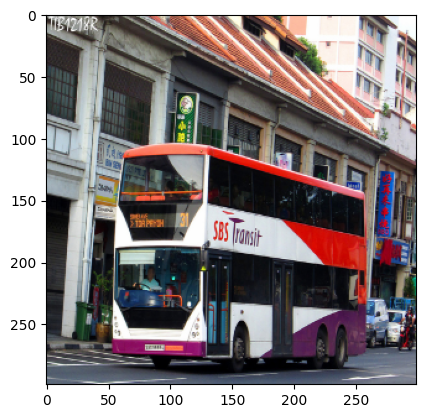

In [46]:
# plt.imshow(selected_images[0])
# generate_caption(selected_images[0], t=1)

'there is a glass of water on the table'

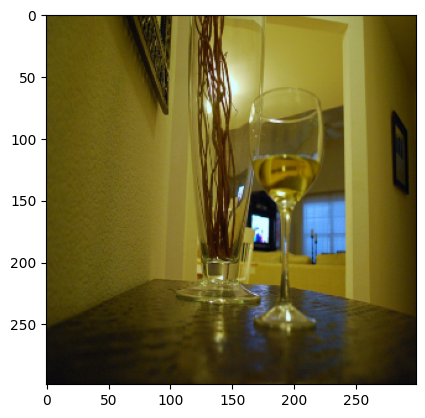

In [47]:
# plt.imshow(selected_images[2])
# generate_caption(selected_images[2], t=1)

'skate boarder sees in air over concrete slopes .'

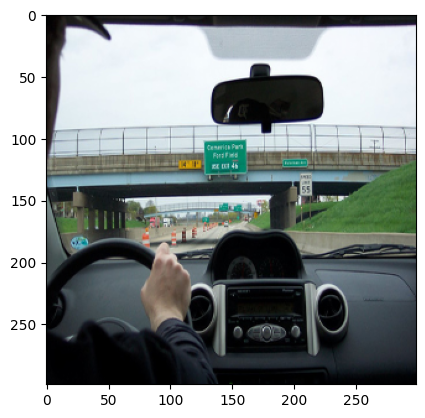

In [48]:
# plt.imshow(selected_images[4])
# generate_caption(selected_images[4], t=1)

'a women who is standing on a beach with a green field .'

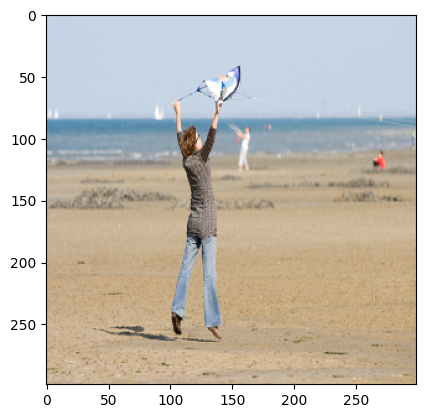

In [49]:
# plt.imshow(selected_images[6])
# generate_caption(selected_images[6], t=1)

'an older man in a wheelchair texting while having fun .'

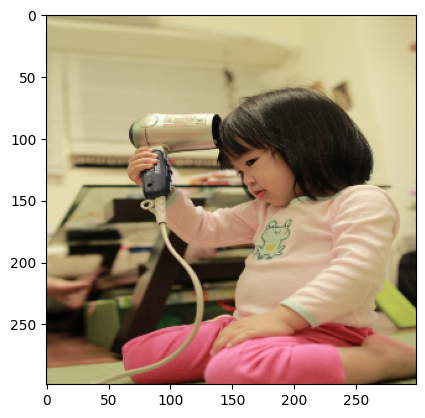

In [50]:
# plt.imshow(selected_images[8])
# generate_caption(selected_images[8], t=1)

'a man showing a #UNK# for the kitchen writing to the camera .'

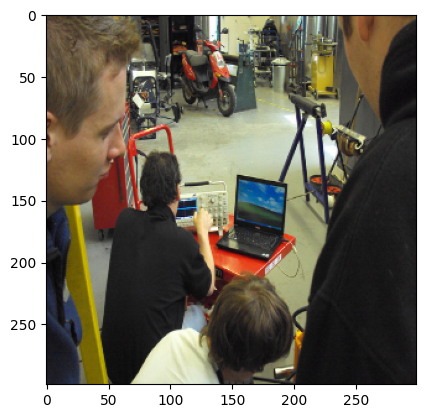

In [51]:
# plt.imshow(selected_images[10])
# generate_caption(selected_images[10], t=1)

Since mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), and number of epoches is 12

In [25]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
epo_n = 12
network = CaptionNet(n_tokens, emb_size=64, lstm_units=128).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
epo_n = epo_n + 1
n_batches_per_epoch = len(train_img_codes) // batch_size + 1
n_validation_batches = len(val_img_codes) // batch_size + 1

train_loss_list = []
val_loss_list = []

network.to(DEVICE)

for epoch in range(epo_n):

    train_loss = 0
    network.train()
    for _ in tqdm.tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)


        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.detach().cpu().numpy()

    train_loss /= n_batches_per_epoch
    train_loss_list.append(train_loss)

    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    val_loss_list.append(val_loss)

    clear_output()
    print(f"epoch {epoch} finished")

print(list(range(epo_n)))
print("Train losses:", train_loss_list)
print("Validation losses:", val_loss_list)
print("Finished!")

epoch 12 finished
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Train losses: [4.246844910944883, 3.3427391103827038, 3.0530525892972946, 2.8999829679154434, 2.801710469218401, 2.73281032162217, 2.6857715220405507, 2.6501216653447885, 2.6114354491806946, 2.579413844415775, 2.556279728618952, 2.5364890224658527, 2.5221124552190304]
Validation losses: [3.5705071777425785, 3.1718887616229314, 2.9779455507955244, 2.8672723385595504, 2.7974864257279264, 2.7467921703092513, 2.7052132801343034, 2.686388833548433, 2.654627802551434, 2.6316811320602254, 2.635501984627016, 2.592017158385246, 2.596266192774619]
Finished!


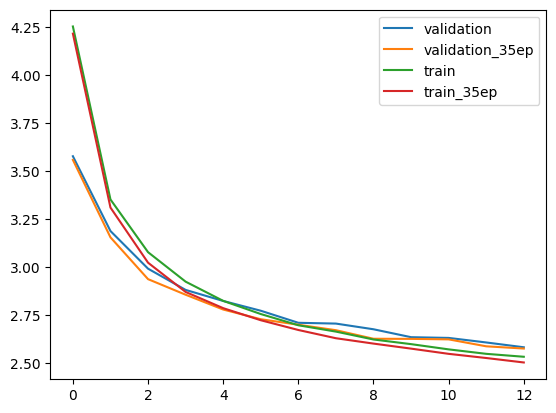

In [55]:
# note: validation and train losses for larger model are changing. This part is done to understand the scale of losses as requested in the final task
Validation_losses_4= [3.577284933418356, 3.187626246483095, 2.9915258551156647, 2.8809249272910495, 2.8233211963407454, 2.7724274281532533, 2.709558412592898, 2.705484761986681, 2.675878304307179, 2.634588377450102, 2.630827775565527, 2.6071428175895446, 2.582095041069933]
Train_losses_4 = [4.25319607097369, 3.351999696057576, 3.07743856511437, 2.9239028703707914, 2.8238006280018735, 2.755260401333754, 2.696746228692623, 2.6636911060374517, 2.622601417108224, 2.598411740018771, 2.571118058780065, 2.547921376446119, 2.53262192899218]

plt.plot(Validation_losses_4, label='validation')
plt.plot(val_loss_list[:13], label='validation_35ep')
plt.plot(Train_losses_4, label = 'train')
plt.plot(train_loss_list[:13], label = 'train_35ep')
plt.legend()
plt.show()

We see that the losses are a bit higher compared to the optimal set of epochs. ~+10% compared to the optimal base of 35 epochs. In absolute figures, it is not that critical (2.6 vs 2.4).

'a city bus pulling into a bus stop .'

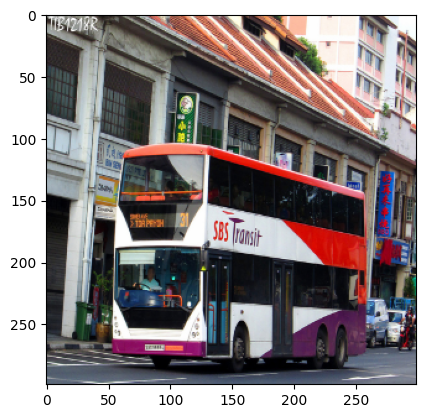

In [56]:
plt.imshow(selected_images[0])
generate_caption(selected_images[0], t=1)

'a cup of red wine surrounded by a wine glass .'

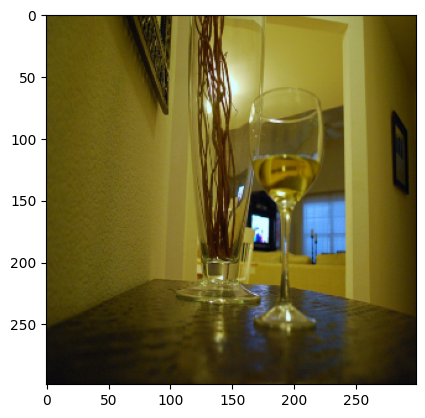

In [57]:
plt.imshow(selected_images[2])
generate_caption(selected_images[2], t=1)

'a man stands by a pole with a demonic wheel carrying its door'

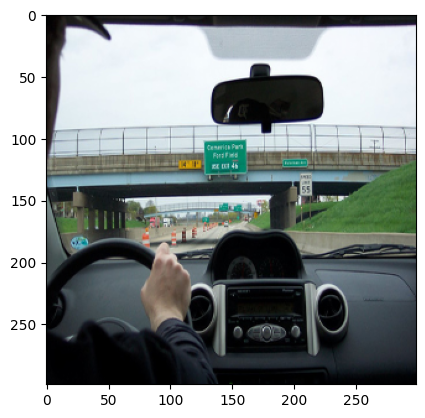

In [58]:
plt.imshow(selected_images[4])
generate_caption(selected_images[4], t=1)

'a young man is playing football on a beach .'

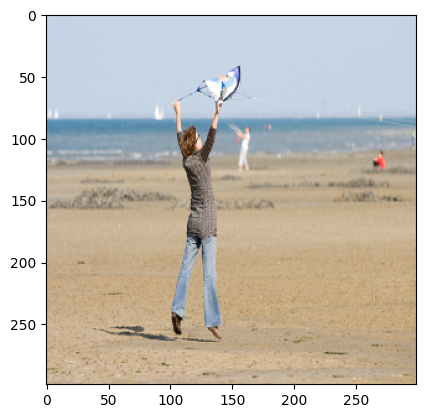

In [59]:
plt.imshow(selected_images[6])
generate_caption(selected_images[6], t=1)

'a woman in a purple shirt using a toothbrush .'

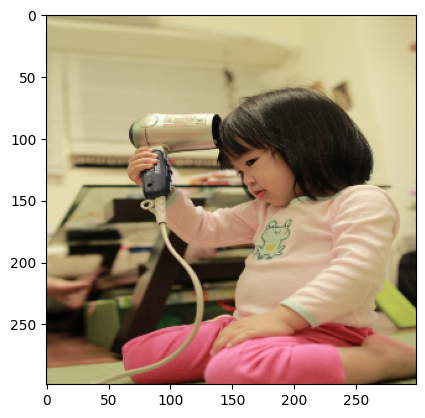

In [60]:
plt.imshow(selected_images[8])
generate_caption(selected_images[8], t=1)

'a couple of men working on desks on a couch .'

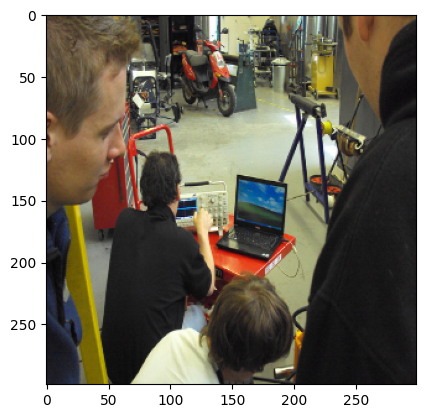

In [61]:
plt.imshow(selected_images[10])
generate_caption(selected_images[10], t=1)

The model with less epochs performs worse compared to the model from 3rd task.

It can distinguish bus, glass of wine, and laptop.

For more complex backgrounds it fails miserably (sand vs rain, fan vs pizza and umbrella, group of men vs group of girls, inside interior of car, etc.)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
def save_model(model, optimizer, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'vocab': vocab,
        'word_to_index': word_to_index,
        'index_to_word': {i: w for w, i in word_to_index.items()},
        'n_tokens': n_tokens
    }, save_path)
    print(f'Model saved to {save_path}')

def load_model(save_path):
    checkpoint = torch.load(save_path)
    n_tokens = checkpoint['n_tokens']
    vocab = checkpoint['vocab']
    word_to_index = checkpoint['word_to_index']

    # Recreate the exact same model purely from the file
    model = CaptionNet(n_tokens=n_tokens)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load the state of the optimizer
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.eval()  # Set the model to evaluation mode

    return model, optimizer, vocab, word_to_index


In [31]:
save_model(network, optimizer, '/content/drive/My Drive/web_app_v4.pth')


Model saved to /content/drive/My Drive/web_app_v4.pth


In [33]:
checkpoint = torch.load('/content/drive/My Drive/web_app_v4.pth', map_location=DEVICE)


In [35]:
print(checkpoint.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'vocab', 'word_to_index', 'index_to_word', 'n_tokens'])


In [77]:
n_tokens

10403